In [28]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms , models


In [29]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms , models


In [30]:
import os
import shutil
import random

# Updated paths
train_path = '/kaggle/input/bird-species-classification-220-categories/Train/'
val_path = '/kaggle/working/valid/'  # New validation path in a writable location
test_path = '/kaggle/input/bird-species-classification-220-categories/Test/'

# Create validation directory if it doesn't exist
os.makedirs(val_path, exist_ok=True)

# List all classes in the training data
classes = os.listdir(train_path)

# Create validation folders for each class
for cls in classes:
    # Create a new folder for the validation class
    os.makedirs(os.path.join(val_path, cls), exist_ok=True)
    
    # Get the list of all files in the class directory
    all_files = os.listdir(os.path.join(train_path, cls))
    
    # Shuffle the list of files
    random.shuffle(all_files)
    
    # Determine the number of validation samples (20%)
    n_val_samples = int(0.2 * len(all_files))
    
    # Select files for validation
    val_files = all_files[:n_val_samples]
    
    # Copy validation files to the validation directory
    for file in val_files:
        src_path = os.path.join(train_path, cls, file)
        dst_path = os.path.join(val_path, cls, file)
        shutil.copy(src_path, dst_path)

print("Validation dataset created with the following class distribution:")
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(val_path, cls)))} files")


Validation dataset created with the following class distribution:
Yellow_Warbler: 18 files
Caspian_Tern: 17 files
Harris_Sparrow: 16 files
Cactus_Wren: 17 files
Blue_winged_Warbler: 16 files
Painted_Bunting: 16 files
Black_and_white_Warbler: 16 files
Scarlet_Tanager: 15 files
Common_Yellowthroat: 16 files
Fish_Crow: 17 files
Pied_Kingfisher: 15 files
Fox_Sparrow: 16 files
Rock_Wren: 18 files
House_Sparrow: 17 files
Magnolia_Warbler: 17 files
Red_legged_Kittiwake: 16 files
Brown_Thrasher: 17 files
Scott_Oriole: 17 files
Baird_Sparrow: 14 files
Nighthawk: 16 files
Long_tailed_Jaeger: 14 files
Red_winged_Blackbird: 18 files
Pied_billed_Grebe: 17 files
Bank_Swallow: 17 files
American_Pipit: 17 files
Vesper_Sparrow: 16 files
Mangrove_Cuckoo: 14 files
Green_tailed_Towhee: 17 files
Hooded_Warbler: 16 files
Geococcyx: 15 files
Red_bellied_Woodpecker: 17 files
Cape_Glossy_Starling: 17 files
Green_Violetear: 16 files
Canada_Warbler: 16 files
Loggerhead_Shrike: 16 files
Eastern_Towhee: 15 files
G

In [31]:
train_path = '/kaggle/input/bird-species-classification-220-categories/Train/'
val_path = '/kaggle/working/valid/'  # Path for validation dataset
test_path = '/kaggle/input/bird-species-classification-220-categories/Test/'

# Get the number of classes in the training data
n_train = len(os.listdir(train_path))
print("The number of classes are:", n_train)

The number of classes are: 200


species: Grasshopper_Sparrow


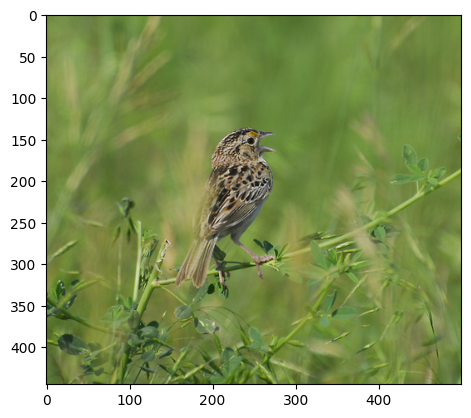

In [32]:
fold = np.random.choice(os.listdir(train_path))
all_imgs= os.listdir(train_path + fold)
img_name = np.random.choice(all_imgs)
img = cv2.imread(train_path + fold +"/"+img_name)
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
print("species:",fold)
plt.imshow(img)
plt.show()

In [33]:
#hyperparameters
BATCH_SIZE = 64
LR = 0.001
NUM_EPOCHS = 10

In [34]:
#Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((244 , 244), antialias= True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225])
])

In [35]:
#Dataset
train_dataset = torchvision.datasets.ImageFolder(root = train_path , transform = transform)
val_dataset = torchvision.datasets.ImageFolder(root = val_path , transform = transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_path , transform = transform)

In [36]:
#dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [37]:
#model
model = models.resnet18(pretrained = True)

In [38]:
final_layer_infeatures = model.fc.in_features

In [39]:
model.fc = nn.Linear(final_layer_infeatures , n_train)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
device

device(type='cuda')

In [41]:
fin_model = model.to(device)

In [42]:
# optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [43]:
import torch

# Directory to save the model
MODEL_SAVE_PATH = '/kaggle/working/bird_classification_modelll.pth'

all_train_losses = []
all_val_losses = []

for EPOCH in range(NUM_EPOCHS):
    train_epoch_loss = 0
    total_train_samples = 0
    total_train_correct = 0
    
    # Training Loop
    for (images, labels) in train_loader:
        total_train_samples += images.shape[0]
        fin_model.train()
        
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        
        output = fin_model(images)
        loss = loss_fn(output, labels)
        
        train_epoch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track training accuracy
        _, indices = torch.max(output, dim=1)
        total_train_correct += (indices == labels).sum().item()

    # Validation Loop
    val_epoch_loss = 0
    total_val_samples = 0
    total_val_correct = 0
    
    fin_model.eval()
    with torch.no_grad():
        for (images, labels) in val_loader:  # Make sure to use val_loader here
            total_val_samples += images.shape[0]
            
            if torch.cuda.is_available():
                images = images.to(device)
                labels = labels.to(device)
            
            output = fin_model(images)
            loss = loss_fn(output, labels)

            val_epoch_loss += loss.item()
    
            _, indices = torch.max(output, dim=1)
            total_val_correct += (indices == labels).sum().item()
    
    # Calculate losses and accuracies
    if total_train_samples > 0:
        train_loss = train_epoch_loss / total_train_samples
        train_accuracy = total_train_correct / total_train_samples
    else:
        train_loss = float('inf')  # Handle edge case
        train_accuracy = 0.0

    if total_val_samples > 0:
        val_loss = val_epoch_loss / total_val_samples
        val_accuracy = total_val_correct / total_val_samples
    else:
        val_loss = float('inf')  # Handle edge case
        val_accuracy = 0.0

    all_train_losses.append(train_loss)
    all_val_losses.append(val_loss)

    print(f"Epoch {EPOCH + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
    
    # Save model after each epoch (optional: you can also save only the final model)
    torch.save(fin_model.state_dict(), MODEL_SAVE_PATH)

# Save the final model state (if not saving after every epoch)
torch.save(fin_model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")


Epoch 1: Train Loss: 0.0539, Val Loss: 0.0387, Train Acc: 0.2239, Val Acc: 0.3353
Epoch 2: Train Loss: 0.0285, Val Loss: 0.0242, Train Acc: 0.5012, Val Acc: 0.5531
Epoch 3: Train Loss: 0.0183, Val Loss: 0.0167, Train Acc: 0.6614, Val Acc: 0.6887
Epoch 4: Train Loss: 0.0118, Val Loss: 0.0109, Train Acc: 0.7752, Val Acc: 0.7950
Epoch 5: Train Loss: 0.0065, Val Loss: 0.0046, Train Acc: 0.8860, Val Acc: 0.9206
Epoch 6: Train Loss: 0.0054, Val Loss: 0.0068, Train Acc: 0.9049, Val Acc: 0.8750
Epoch 7: Train Loss: 0.0062, Val Loss: 0.0038, Train Acc: 0.8892, Val Acc: 0.9275
Epoch 8: Train Loss: 0.0025, Val Loss: 0.0012, Train Acc: 0.9607, Val Acc: 0.9819
Epoch 9: Train Loss: 0.0018, Val Loss: 0.0010, Train Acc: 0.9736, Val Acc: 0.9859
Epoch 10: Train Loss: 0.0024, Val Loss: 0.0009, Train Acc: 0.9602, Val Acc: 0.9903
Model saved to /kaggle/working/bird_classification_modelll.pth


In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Performance metrics function
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            if torch.cuda.is_available():
                images = images.to(device)
                labels = labels.to(device)
                
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", conf_matrix)

# Call the function for validation set
evaluate_model(fin_model, val_loader, device)


Precision: 0.9910
Recall: 0.9903
F1 Score: 0.9902
Confusion Matrix:
 [[16  0  0 ...  0  0  0]
 [ 0 17  0 ...  0  0  0]
 [ 0  0 16 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 14  0]
 [ 0  0  0 ...  0  0  6]]


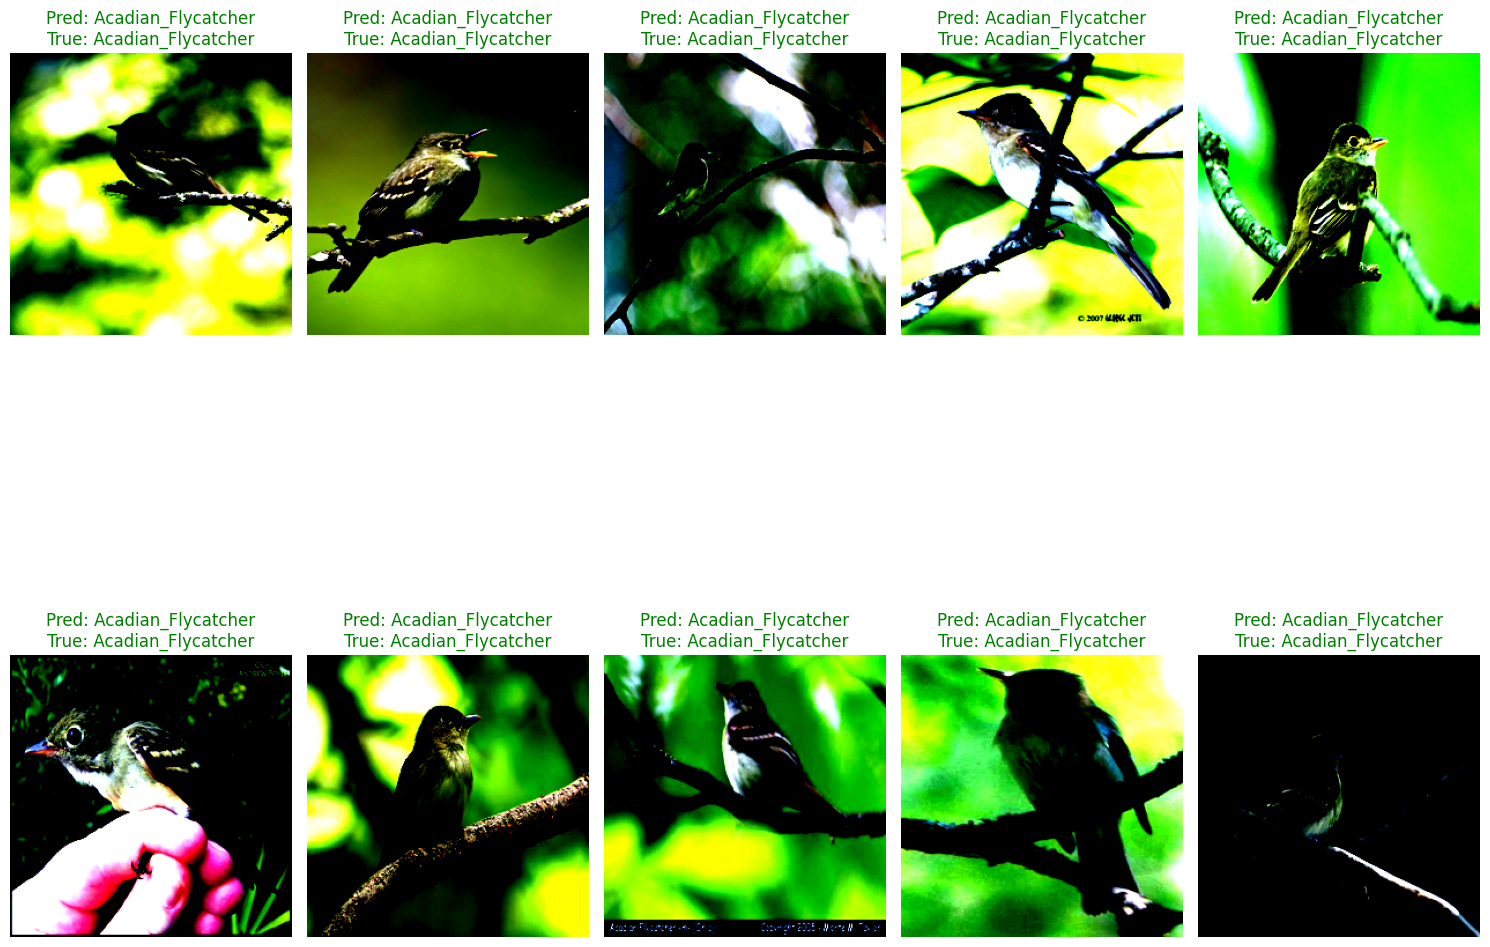

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize model predictions
def visualize_predictions(model, dataloader, device, class_names, num_images=10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 15))
    
    with torch.no_grad():
        for images, labels in dataloader:
            if torch.cuda.is_available():
                images = images.to(device)
                labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Convert images to CPU for visualization
            images = images.cpu().numpy().transpose((0, 2, 3, 1))
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()

            for i in range(images.shape[0]):
                if images_shown == num_images:
                    break

                ax = plt.subplot(num_images // 5, 5, images_shown + 1)
                ax.axis('off')
                
                # Show the image
                plt.imshow(images[i])
                
                # Set the title to True/False and predicted/actual labels
                color = "green" if preds[i] == labels[i] else "red"
                ax.set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}", color=color)
                
                images_shown += 1
            if images_shown == num_images:
                break
    plt.tight_layout()
    plt.show()

# Assuming you have a list of class names (bird species) in your dataset
class_names = sorted(os.listdir(train_path))  # Adjust train_path according to your setup

# Visualize model predictions using validation data
visualize_predictions(fin_model, val_loader, device, class_names, num_images=10)
